作者:知乎[HexUp](https://www.zhihu.com/people/qd6pwu4)发布于 2018-07-14 14:39

PyTorch的0.4版本带来了不小的变化，其中我最喜欢的是：

Tensor和Variable这两个类合并了。原来nn的input是一个variable，现在可以直接用tensor。这样在语法上更简洁易用，对初学者也更容易理解。

Windows support。官方支持了windows，作为一个最近回归了windows的人很开心哈哈。

之前内存泄露的问题似乎也解决了，所以我又开心地从Tensorflow蹦回了PyTorch，顺便写点教程。先从最基本的开始，今天这篇文章讲怎么完成图像分类的任务。阅读前假设对神经网络和Python有一定了解。

通常我们在使用PyTorch的时候会用到两个包，一个是torch，一个是torchvision。其中torch是关于运算的包，torchvision则是打包了一些数据集，另外用torch实现了一些常见的神经网络模型，比如ResNet。

我们使用CIFAR-10作为数据集，包含了10个类别60000张图片，每张图片的大小为32x32，其中训练图片50000张，测试图片10000张。下图是一些示例

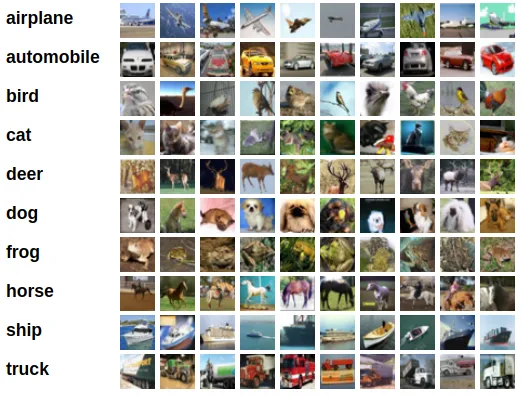
CIFAR-10示例

torchvision中已经打包好了这个数据集，我们不用自己下载，直接如下调用就可以了。

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# cifar-10官方提供的数据集是用numpy array存储的
# 下面这个transform会把numpy array变成torch tensor，然后把rgb值归一到[0, 1]这个区间
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 在构建数据集的时候指定transform，就会应用我们定义好的transform
# root是存储数据的文件夹，download=True指定如果数据不存在先下载数据
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)


Files already downloaded and verified


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# cifar-10官方提供的数据集是用numpy array存储的
# 下面这个transform会把numpy array变成torch tensor，然后把rgb值归一到[0, 1]这个区间
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 在构建数据集的时候指定transform，就会应用我们定义好的transform
# root是存储数据的文件夹，download=True指定如果数据不存在先下载数据
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)


Files already downloaded and verified


load完了之后我们看看这两个数据集的信息

In [10]:
print(cifar_train)
print(cifar_test)

# 数据其实是用numpy array存储的，label是个list

# 旧版
# print(cifar_train.train_data.shape)
# print(type(cifar_train.train_labels), len(cifar_train.train_labels))
# print(cifar_test.test_data.shape)
# print(type(cifar_test.test_labels), len(cifar_test.test_labels))

# 新版
print(cifar_train.data.shape)
print(type(cifar_train.targets), len(cifar_train.targets))
print(cifar_test.data.shape)
print(type(cifar_test.targets), len(cifar_test.targets))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
(50000, 32, 32, 3)
<class 'list'> 50000
(10000, 32, 32, 3)
<class 'list'> 10000


In [11]:
# 在训练的时候我们可以自己写代码手动遍历数据集，指定batch和遍历方法，不过PyTorch提供了一个DataLoader类来方便我们完成这些操作。
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=32, shuffle=True)

现在我们来定义卷积神经网络，为了简单起见，我们使用经典的LeNet，它包含两个卷积层和三个全连接层，网络结构如图
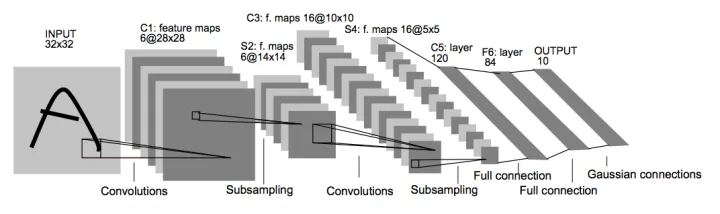

在PyTorch中定义神经网络非常简单，第一步先是继承nn.module这个类，然后定义如下两个函数，一般的网络这样操作就足够了

In [12]:
class LeNet(nn.Module):
    # 一般在__init__中定义网络需要的操作算子，比如卷积、全连接算子等等
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv2d的第一个参数是输入的channel数量，第二个是输出的channel数量，第三个是kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 由于上一层有16个channel输出，每个feature map大小为5*5，所以全连接层的输入是16*5*5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # 最终有10类，所以最后一个全连接层输出数量是10
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)

    # forward这个函数定义了前向传播的运算，只需要像写普通的python算数运算那样就可以了
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 下面这步把二维特征图变为一维，这样全连接层才能处理
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

PyTorch具有自动求导功能，我们不需要自己写backward函数，所以很直观方便，写神经网络的结构就像写普通的数学运算公式一样。定义好网络之后我们就可以训练了，训练的代码也非常简单。首先，我们先构建一个网络实例。由于需要用到GPU，所以先获取device，然后再把网络的参数复制到GPU上

In [13]:
# 如果你没有GPU，那么可以忽略device相关的代码
device = torch.device("cuda:0")
net = LeNet().to(device)

然后我们需要定义Loss函数和优化方法，最简单的就是使用SGD了。PyTorch都预先定义好了这些东西

In [14]:
# optim中定义了各种各样的优化方法，包括SGD
import torch.optim as optim

# CrossEntropyLoss就是我们需要的损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

下面我们正式开始训练

In [15]:
print("Start Training...")
for epoch in range(30):
    # 我们用一个变量来记录每100个batch的平均loss
    loss100 = 0.0
    # 我们的dataloader派上了用场
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 注意需要复制到GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss100 += loss.item()
        if i % 100 == 99:
            print('[Epoch %d, Batch %5d] loss: %.3f' % (epoch + 1, i + 1, loss100 / 100))
            loss100 = 0.0

print("Done Training!")

Start Training...
[Epoch 1, Batch   100] loss: 2.305
[Epoch 1, Batch   200] loss: 2.305
[Epoch 1, Batch   300] loss: 2.303
[Epoch 1, Batch   400] loss: 2.302
[Epoch 1, Batch   500] loss: 2.302
[Epoch 1, Batch   600] loss: 2.300
[Epoch 1, Batch   700] loss: 2.299
[Epoch 1, Batch   800] loss: 2.297
[Epoch 1, Batch   900] loss: 2.295
[Epoch 1, Batch  1000] loss: 2.292
[Epoch 1, Batch  1100] loss: 2.286
[Epoch 1, Batch  1200] loss: 2.277
[Epoch 1, Batch  1300] loss: 2.253
[Epoch 1, Batch  1400] loss: 2.215
[Epoch 1, Batch  1500] loss: 2.149
[Epoch 2, Batch   100] loss: 2.046
[Epoch 2, Batch   200] loss: 2.009
[Epoch 2, Batch   300] loss: 1.953
[Epoch 2, Batch   400] loss: 1.941
[Epoch 2, Batch   500] loss: 1.931
[Epoch 2, Batch   600] loss: 1.899
[Epoch 2, Batch   700] loss: 1.857
[Epoch 2, Batch   800] loss: 1.854
[Epoch 2, Batch   900] loss: 1.807
[Epoch 2, Batch  1000] loss: 1.788
[Epoch 2, Batch  1100] loss: 1.791
[Epoch 2, Batch  1200] loss: 1.752
[Epoch 2, Batch  1300] loss: 1.744
[E

以上代码中，核心的代码是下面五行，我用注释解释了每一行的作用

In [16]:
# 首先要把梯度清零，不然PyTorch每次计算梯度会累加，不清零的话第二次算的梯度等于第一次加第二次的       
optimizer.zero_grad()
# 计算前向传播的输出
outputs = net(inputs)
# 根据输出计算loss
loss = criterion(outputs, labels)
# 算完loss之后进行反向梯度传播，这个过程之后梯度会记录在变量中
loss.backward()
# 用计算的梯度去做优化
optimizer.step()

ok，训练完了之后我们来检测一下准确率，我们用训练好的模型来预测test数据集

In [17]:
# 构造测试的dataloader
dataiter = iter(testloader)
# 预测正确的数量和总数量
correct = 0
total = 0
# 使用torch.no_grad的话在前向传播中不记录梯度，节省内存
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # 预测
        outputs = net(images)
        # 我们的网络输出的实际上是个概率分布，去最大概率的哪一项作为预测分类
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 64 %


在我这里最终训练了30个epoch之后准确率为63%。

以上就是用PyTroch做图像分类的基本步骤，是不是很简单呢?